# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import tensorflow_datasets as tfds

# mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

In [3]:
mnist = tfds.load('mnist', split='train', as_supervised=True)

Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

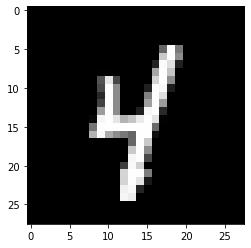

In [4]:
for img, lbl in mnist.take(1):
    img = img.numpy()
    plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [5]:
from tensorflow.keras.models import Model

## Training

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss_history = []

mnist_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(input_shape=(28,28,)),
                tf.keras.layers.Dense(units=32, activation="relu"),
                tf.keras.layers.Dense(units=784)
            ])

print(mnist_model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [7]:
mnist = tfds.load('mnist', split='train', as_supervised=True)
mnist = mnist.batch(128)

for epoch in range(10):
    for (batch, (images, labels)) in enumerate(mnist):
        images = images/255
        
        with tf.GradientTape() as tape:
            logits = mnist_model(images, training=True)

            loss_value = tf.nn.sigmoid_cross_entropy_with_logits(images.numpy().astype("float32").reshape(logits.shape), logits)
            cost = tf.reduce_mean(loss_value)
        
        grads = tape.gradient(cost, mnist_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    loss_history.append(cost.numpy().mean())
        
    print ('Epoch {} finished'.format(epoch+1))

Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished



In [8]:
print(loss_history)

[0.14683414, 0.11636843, 0.10232723, 0.09445478, 0.09027809, 0.087570034, 0.08636131, 0.085740946, 0.08537544, 0.08514088]


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

In [9]:
mnist = tfds.load('mnist', split='train', as_supervised=True)

reconstructed = []
in_imgs = []
for in_img, _ in mnist.take(10):
    in_img = np.array([in_img])
    vals = mnist_model([in_img/255])

    reconstructed.append(tf.nn.sigmoid(vals).numpy())
    in_imgs.append(in_img)



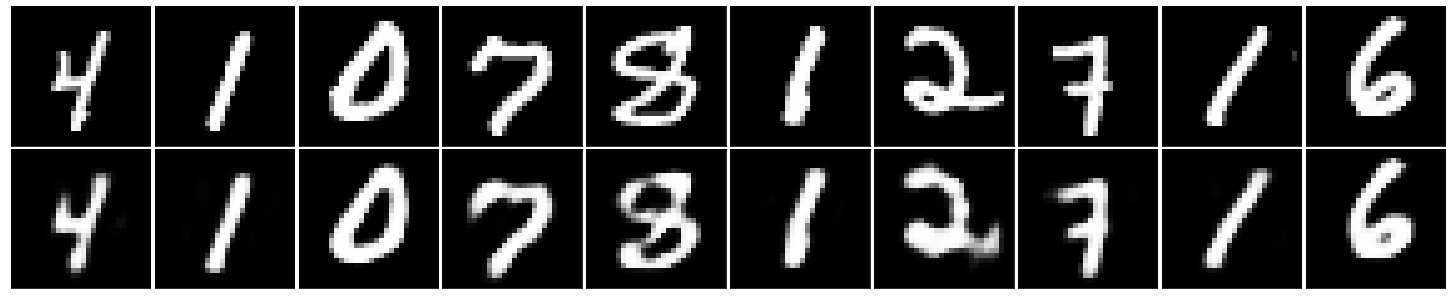

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.